# Document Scope


This notebook is intended for readers with statistical foundations as a gentle introduction to Bayesian A/B testing (with early stopping). A lot of mathematical details are not included in the notebook for conciseness.

In terms of practical context, we strive to measure the treatment effect on a conversion rate ($\lambda$), defined as a probability $\in$ (0, 1).

The hypothesis of interest are:

$$ \mathbf{H_0}: \lambda_{control} = \lambda_{treatment} \qquad\quad \mathbf{H_1}: \lambda_{control} \neq \lambda_{treatment} $$

Where a null hypothesis acceptance will imply no significant treatment effect, and a rejection is associated with a signficant treatment effect (note: in this design not necessarily positive).

The remainder of the notebook is structured as follows:
0. Introduction Bayesian Inference
1. DGP
2. Priors
3. Bayes Factors
4. Posterior & Inference
5. Early Stopping

---
# Part 0: Introduction Bayesian Inference


The main distinguishing characteristic of Bayesian inference is its ability to incorporate information that is not captured in observed data in a statistically valid way

This concept is known as including a **prior** that is intended to reflect a belief about an outcome variable *before seeing any data*. This could come in the form of expert opinions, past research, gut feeling, business context, etc. Consequently, this prior is combined with the observational data

The prior values should be specified before commencing analysis. Then, as more empirical evidence is observed we combine the two information sources to produce and apply our inference on what is known as a **posterior**.

$$
Posterior = Prior \times \text{Observed evidence}
$$



In [245]:
# Import some basic packages
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Control randomness for reproducibility
random.seed(1)

---
# Part 1: Data Generating Process


In this A/B test example, the VOI is ```conversion_rate```, a commonly relevant (binary) variable that we can simulate by sampling from a **Bernoulli distribution**. The treatment effect can be simulated by changing the mean of the control/treatment group.

User Input:
- ``n`` = Sample sizes
- ``true_prob`` = True conversion probability (with optional treatment effect)

Output:
- Two dictionaries: ```C``` (control), ```T``` (Treatment)
  - ``n`` = Sample size
  - ``true_prob`` = conversion rate of true DGP
  - ``sample`` = conversion outcomes
  - ``converted`` = total number of conversions = sum(sample)
  - ``sample_conversion_rate`` = conversion rate of sample

In [246]:
# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 100_000, "true_prob": 0.5}
T = {"n": 100_000, "true_prob": 0.52}

In [247]:
def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structure
print(f"Control: {C['sample'][:10]}, Sample Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Sample Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")
print(f"\nsimulated treatment effect = {round((T['true_prob'] - C['true_prob'])*100, 2)}%")

Control: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1], Sample Conversion_Rate = 0.5004 (true = 0.5) 
Treatment: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1], Sample Conversion_Rate = 0.51902 (true = 0.52)

simulated treatment effect = 2.0%


---
# Part 2: Prior


When considering priors in Bayesian A/B testing, to understand (and control) their effect, it is important to recognise where exactly they are present.

The following section elaborates on 2 types of priors:
- Prior odds (Hypothesis prior)
- Marginal likelihood prior (Parameter prior)

## Prior 1: Prior odds


**Definition: prior beliefs about probability of hypothesis being true.**

$$
Posterior = \mathbf{Prior} \times BF
$$


$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{\mathbf{P(H_1)}}{\mathbf{P(H_0)}} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$

User input:
- ```prior_odds``` = relative odds of alternative/null hypothesis being true. For example, a *prior_odds = 2* reflect 2:1 odds in favor of $H_1$ and thus claiming a prior belief of $H_1$ having twice as much likelihood of being true when compared to the $H_0$.


In [248]:
# Define Prior odds
prior_odds = 1

## Prior 2: Marginal likelihood prior


**Definition: prior beliefs about DGP parameter distributions, conditional on a hypothesis being true**

In Bayesian A/B testing, observational evidence is captured in so-called **Bayes Factors (BF)**.

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$


A Bayes Factor is a ratio of **Marginal Likelihoods**, not to be mistaken for normal likelihoods. In short: a Likelihood quantifies how probable the observed data is for a specific parameter value, while marginal likelihood averages the data's probability over all plausible parameter values within a given model through integration.

$$
P(\text{Data}| H_0) = \int P(\text{Data}|\lambda, H_0) \mathbf{P(\lambda|H_0)} \, d\lambda
$$

In this context, the parameter $\lambda$ represents the conversion rate for the treatment/control group's (assumed) DGP, i.e. $data \sim Bernoulli(\lambda)$, over which we need to specify a prior as well. This affects how the averaging process in marginal likelihood is executed. In this context, the prior reflects the expected probability distribution of the conversion rate parameter for the bernoulli distribution behind the control/treatment data, thus a *prior belief on a DGP parameter distribution*.

The assumed distribution here is a **Beta-Binomial distribution**, a distribution that fits our purposes because:
- Only defined in range (0,1), just like our target variable ```conversion rate``` (probability)
- Marginal Likelihood computation convenience
- Beta-distributed priors are *conjugate*, meaning that they are guarenteed to preserve their beta distribution after being updated with data.

see: https://medium.com/@ro.mo.flo47/the-beta-binomial-model-an-introduction-to-bayesian-statistics-154395875f93

User input:
- ```mean``` = prior belief on conversion rate
- ```weight``` = prior distribution variance, or practically speaking, the degree of certainty in prior belief (recommended to play around with multiple values while inspecting the prior visualisations).

In [249]:
# Specify prior distribution (mean + "weight" as proxy for variance)
mean_C, weight_C = 0.5, 1000
mean_T, weight_T = 0.52, 1000

Helper function to abstract away, the transformation steps to get from tangible prior beliefs on effect magnitude (mean) & associated certainty (weight) to Beta distributions parameters.

Output:
- Two dictionaries ```C_prior``` (Control), ```T_prior``` (Treatment):
  - ```alpha``` = shape & location parameter, skews distribution to higher conversion rates ($\lambda$ = 1)
  - ```beta``` = shape & location parameter, skews distribution to lower conversion rates ($\lambda$ = 0)

In [250]:
# Help function with determining alpha & beta
def beta_helper(prior_prob, weight):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 2) * weight + 1
    b = (1 - round(prior_prob, 2)) * weight + 1
    return round(a), round(b)

# parameters: Mean, weight
C_prior, T_prior = dict(), dict()
C_prior["alpha"], C_prior["beta"] = beta_helper(mean_C, weight_C)
T_prior["alpha"], T_prior["beta"] = beta_helper(mean_T, weight_T)

Plot priors:

using helper function:


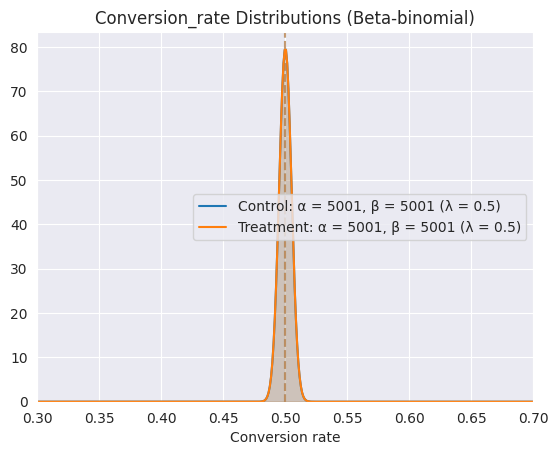

In [251]:
# Visualisation function for beta distribution
def plot_beta_distribution(T_alpha, T_beta, T_mean, C_alpha, C_beta, C_mean):
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    C_dist = stats.beta.pdf(x, C_alpha, C_beta)
    T_dist = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot distributions & means
    plt.plot(x, C_dist, label=f'Control: α = {C_alpha}, β = {C_beta} (λ = {C_mean})', color = _colors[0])
    plt.fill_between(x, C_dist, color = _colors[0], alpha=0.2)
    plt.axvline(C_mean, color = _colors[0], linestyle = "--", alpha = 0.5)

    plt.plot(x, T_dist, label=f'Treatment: α = {T_alpha}, β = {T_beta} (λ = {T_mean})', color = _colors[1])
    plt.fill_between(x, T_dist, color = _colors[1], alpha=0.2)
    plt.axvline(T_mean, color = _colors[1], linestyle = "--", alpha = 0.5)

    plt.title('Conversion_rate Distributions (Beta-binomial)')
    plt.xlabel('Conversion rate')
    plt.xlim(0.3, 0.7)
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()

print("using helper function:")
plot_beta_distribution(T_prior["alpha"], T_prior["beta"], mean_T, C_prior["alpha"], C_prior["beta"], mean_C)

---
# Part 3: Bayes Factor

The Bayes Factor (BF), defined as a ratio of Marginal Likelihoods (not to be mistaken for a regular likelihood ratio) and can be interpreted as the data-driven component of Bayesian Infernece as all observational information should be captured in this term.

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$

The Bayes factor reflect relative odds of alternative/null hypothesis being true, purely based on the data observed. For example, a *BF = 2* reflect 2:1 odds in favor of $H_1$ and thus claiming a prior belief of $H_1$ having twice as much likelihood of being true when compared to the $H_0$. An important property in Bayesian A/B testing is that this interpretation is preserved, even under early stopping of experiments (https://arxiv.org/abs/1602.05549).

## Derivation Bayes Factor


Given a (conjugate) Beta-binomial parameter prior, we can obtain our marginal likelihoods as follows:

$$ P[data|H] = \frac{Beta(\alpha + c, \beta + (n-c) )}{\beta(\alpha, \beta)} = \frac{(
  \frac{\Gamma(\alpha + c)\Gamma(\beta + (n-c))}{\Gamma(\alpha + \beta + n)})
}{(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)})}$$
where:
- $\alpha$, $\beta$ = Beta-prior parameters,
- *c* = total number of conversions
- *n* = sample size.
- $\Gamma(\theta)$ = Gamma function = $\int_0^\infty x^{\theta-1} e^{-x} \, dx$

The main question becomes which parameters to plug in this function, as multiple combinations of values can be justified. To capture the following Hypotheses

$$ \mathbf{H_0}: \lambda_{control} = \lambda_{treatment} \qquad\quad \mathbf{H_1}: \lambda_{control} \neq \lambda_{treatment} $$

we can employ the following design:

### H0: The Null Hypothesis - Same Distribution

- **Marginal Likelihood**:
  $$P[data_{t} + data_{c}|H_0] = \frac{Beta(\alpha_0 + c_t + c_c, \beta_0 + (n_t + n_c - c_t - c_c))}{\beta(\alpha_0, \beta_0)} $$

- **Intuition**:
  We're treating the treatment and control groups as if they're one big group. We're asking, "Given our prior beliefs and the observed data, what's the likelihood that both groups follow the same conversion distribution?"

- **Technical Intuition**:
  Think of it like pooling the results of two A/B test variants ($data_t + data_c$) and evaluating how probable the combined data is, under the assumption that there's no difference between them ($H_0$).
  - Note that for these hypotheses, $\alpha_0$, $\beta_0$ are equal to $\alpha_c$, $\beta_c$ by construction, when assuming no treatment effect on the control group.

### H1: The Alternative Hypothesis - Different Distributions

- **Marginal Likelihood**:
  $$P[data_{t}, data_{c}|H_1] = \frac{Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))}{\beta(\alpha_t, \beta_t)} \times \frac{Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))}{\beta(\alpha_c, \beta_c)} $$

- **Intuition**:
  Here, we're separating the treatment and control groups, evaluating each on its own. It's like asking, "How likely is the data if the treatment and control groups follow different conversion distributions ($H_1$)?"

- **Technical Intuition**:
  It's akin to evaluating two A/B test variants individually. You're trying to determine if each variant's data is more probable under the assumption that they come from distinct underlying distributions.


### Bayes Factor

Using the results above, the Bayes Factor becomes:

$$BF_{H_1|H_0} = \frac{
  P[data_{t}, data_{c}|H_1]}{P[data_{t} + data_{c}|H_0]}
= \frac{(
  \frac{Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))}{\beta(\alpha_t, \beta_t)} \times \frac{Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))}{\beta(\alpha_c, \beta_c)}
)}{
  \frac{Beta(\alpha_0 + c_t + c_c, \beta_0 + (n_t + n_c - c_t - c_c))}{\beta(\alpha_0, \beta_0)}
} $$


## Python implementation

This implementation uses ```scipy.special.betaln```, a beta function that uses logarithms to bypass computational issues we would face otherwise when scaling sample sizes up.

In [252]:
from scipy.special import betaln

def beta_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c):
    # Log probability of data under H0
    log_prob_data_H0 = betaln(alpha_0 + c_t + c_c, beta_0 + n_t + n_c - c_t - c_c) - betaln(alpha_0, beta_0)

    # Log probability of data under H1 for treatment group
    log_prob_data_H1_treatment = betaln(alpha_t + c_t, beta_t + n_t - c_t) - betaln(alpha_t, beta_t)

    # Log probability of data under H1 for control group
    log_prob_data_H1_control = betaln(alpha_c + c_c, beta_c + n_c - c_c) - betaln(alpha_c, beta_c)

    # Log joint probability of data under H1
    log_prob_data_H1 = log_prob_data_H1_treatment + log_prob_data_H1_control

    # Compute Log Bayes Factor and convert to regular Bayes Factor
    log_BF_10 = log_prob_data_H1 - log_prob_data_H0
    bf_10 = np.exp(log_BF_10)

    return bf_10

# Collect the correct parameters:
alpha_0, beta_0 = C_prior["alpha"], C_prior["beta"] # Prior H0 (By design equal to Prior Control)
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"] # Prior Treatment
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"] # Prior Control
c_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
c_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

bayes_factor = beta_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)
print(f"Bayes Factor (BF_10) = {bayes_factor}")

Bayes Factor (BF_10) = 4014879003646.955


---
# Part 4: Posterior & Inference

Given the hypotheses:

$$ \mathbf{H_0}: \lambda_{control} = \lambda_{treatment} \qquad\quad \mathbf{H_1}: \lambda_{control} \neq \lambda_{treatment} $$

By combining the prior with the observational evidence (Bayes Factor), we can now derive the posterior probability for significant treatment effect as follows:

$$
\mathbf{Posterior} = Prior \times BF
$$

$$
\frac{\mathbf{P(H_1| \text{Data})}}{\mathbf{P(H_0| \text{Data})}} = \frac{P(H_1)}{P(H_0)} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$

Note that specific set of hypotheses targets the probability of *a significant treatment effect* ($P[\lambda_t \neq \lambda_c]$), not to be mistaken for the probability of a positive effect (P[$\lambda_t > \lambda_c$]), which would require a one-sided test.

In [253]:
# Calculate post odds & convert to %
post_odds = prior_odds * bayes_factor
prob_effect = round(post_odds / (post_odds + 1) * 100, 2)

print(f"Posterior probability of Signficant Treatment effect: {prob_effect}%")

Posterior probability of Signficant Treatment effect: 100.0%


## Experimentation metrics
Following: https://medium.com/towards-data-science/bayesian-experimentation-metrics-explained-bd2faebd937e

This section covers multiple experiment metrics that can directly be used to drive decision-making. All of these rest on the *posterior probabilities*.



### Uplift


**Definition:** *During the experiment, how much better did the treatment group perform than the control?*

For our particular use-case here, this boils down to a simple difference in conversion rates.

$$ \text{Uplift} = \frac{c_t}{n_t} - \frac{c_c}{n_c}$$

Note that this is simply describing what has occurred within the collected sample, and should not be assumed to necessarily extrapolate to future events.

In [254]:
# Uplift
uplift = round(T["sample_conversion_rate"] - C["sample_conversion_rate"], 4)
print(f"uplift: {uplift}")

uplift: 0.0186


### Chance to beat control

**Definition:** *How likely is it that the Treatment group will out perform the Control group?*

Unlike uplift, chance to beat control is a description of the underlying behaviour of the conversion rate, and it is therefore well suited to be used to draw conclusions about expected future behaviour.

In terms of statistics, this boils down to a one-sided test to check whether the treatment mean ($\lambda_t$) is larger than the control conversion rate ($\lambda_c$), and is calculated as follows:

$$ P[\lambda_t > \lambda_c | data] = \int_0^1 \int_0^{\lambda_t} f_t(\lambda_t) f_c(\lambda_c) d\lambda_c d\lambda_t$$
with $f(\lambda)$ representing the (conjugate) posterior, Beta-Binomial pdf, evaluated in the sample mean $\lambda$ (conversion rate):

$$ f_t(\cdot) = Beta(\alpha_t + c_t, \beta_t + (n_t - c_t)) $$
$$ f_c(\cdot) = Beta(\alpha_c + c_c, \beta_t + (n_c - c_c)) $$

**Implementation:**
Computing these integrals is often analytically complex and therefore troublesome. Instead, we can use **Monte Carlo integration** (i.e., drawing samples and averaging) as a practical and efficient method to approximate the integral's value:

- Sample from posteriors: generate *S* observations (conversion probabilities) for both control and treatment:

$$ x_{t} \sim Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))$$
$$ x_{c} \sim Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))$$

- Compare samples and get winner: evaluate samples in terms of pairs containing one control and one treatment observation, and count the number of occurences where treatment outperformed control, i.e. treatment converted and control didn't.

$$ \#[t > c] = \sum^{S}_{i = 1} I[x_{t,i} > x_{c, i}]$$

- Average comparisons: proportion of treatment exceeding control reflects the estimated chance to beat control.


$$ P[\lambda_t > \lambda_c | data] ≈  \frac{\#[t > c]}{S}$$

Note that it is a binary statistic ("better" or "not better") and should therefor not be linked to any uplift magnitudes.

In [255]:
from scipy.stats import beta

def prob_treatment_greater_than_control(alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c, num_samples = 100_000):
    # Compute posterior parameters
    post_alpha_t, post_beta_t = alpha_t + c_t, beta_t + (n_t - c_t)
    post_alpha_c, post_beta_c = alpha_c + c_c, beta_c + (n_c - c_c)

    # Sample from the posterior distributions
    theta_t_samples = beta.rvs(post_alpha_t, post_beta_t, size = num_samples)
    theta_c_samples = beta.rvs(post_alpha_c, post_beta_c, size = num_samples)

    # Calculate the proportion of times the treatment sample is greater than the control sample
    proportion_greater = np.mean(theta_t_samples > theta_c_samples)

    # Convert to percentage for interpretability
    return round(proportion_greater * 100, 2)

# Collect the correct parameters:
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"] # Prior Treatment
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"] # Prior Control
c_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
c_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

# Calculate the probability
prob_t_wins = prob_treatment_greater_than_control(alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)
print(f"Chance to beat control: {prob_t_wins}%")

Chance to beat control: 100.0%


### Loss

**Definition:** *If we choose the treatment when the control is actually superior, what is the corresponding expected loss?*

In other words, this is a measure that quantifies the risk of a scenario where we choose to roll-out the treatment variant after wrongly identifying a positive effect. This metric can be expressed as follows:

$$ E[\lambda_c - \lambda_t | \lambda_c > \lambda_t] = \int_{0}^{1} \int_{\lambda_t}^{1} (\lambda_c - \lambda_t) \cdot f_t(\lambda_t) \cdot f_c(\lambda_c) \, d\lambda_c \, d\lambda_t $$

here, where we can now conveniently reuse the individual Beta pdfs $f_t(\cdot)$ and $f_c(\cdot)$, we'd usually require the joint pdf $f_{t,c}(\lambda_t, \lambda_c)$, but given the A/B testing setting, we can reasonably assume independence due to their respective isolated DGPs (by design). Moreover, we use the inner integral bounds $\lambda_t$ to 1 ensure we are only considering values where $\lambda_c$ > $\lambda_t$.

**Implementation:**
Like above, we avoid calculating a likely cumbersome integral through **Monte Carlo integration** as follows:

- Sample from posteriors: generate *S* observations (conversion probabilities) for both control and treatment:

$$ x_{t} \sim Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))$$
$$ x_{c} \sim Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))$$

- Compare samples and get difference: evaluate samples in terms of pairs containing one control and one treatment observation and calculate the average loss as follows:

$$  E[\lambda_c - \lambda_t] ≈ \frac{\sum^{S}_{i = 1} \delta_{i}}{S} = \frac{\sum^{S}_{i = 1} x_{c,i} - x_{t, i}}{S}$$

- Condition on control being better: we are only interested in situations where control is indeed better than treatment. Therefore, we only consider the positive values of $\delta_i$:

$$  E[\lambda_c - \lambda_t | \lambda_c > \lambda_t] ≈ \frac{\sum^{S}_{i = 1} I[\delta_i > 0] \cdot \delta_i}{S} = \frac{\sum^{S}_{i = 1} I[x_{c,i} > x_{t, i}](x_{c,i} - x_{t, i})}{S}$$











In [256]:
from scipy.stats import beta

def expected_loss_when_choosing_treatment(alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c, num_samples=10_000):
    # Compute posterior parameters
    post_alpha_t, post_beta_t = alpha_t + c_t, beta_t + (n_t - c_t)
    post_alpha_c, post_beta_c = alpha_c + c_c, beta_c + (n_c - c_c)

    # Sample from the posterior distributions
    theta_t_samples = beta.rvs(post_alpha_t, post_beta_t, size=num_samples)
    theta_c_samples = beta.rvs(post_alpha_c, post_beta_c, size=num_samples)

    # Compute the differences for samples where control > treatment
    differences = theta_c_samples - theta_t_samples
    negative_differences = differences[theta_c_samples > theta_t_samples]

    # Return the (rounded) average loss in %
    if len(negative_differences) > 0:
      expected_loss = np.mean(negative_differences)
      return round(expected_loss, 4)
    # If no samples where treatment < control, return 0 loss (note that this is rounded, as it should always be non-zero following stats concepts)
    else:
      return 0

# Collect the correct parameters:
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"] # Prior Treatment
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"] # Prior Control
c_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
c_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

loss_when_t = expected_loss_when_choosing_treatment(T_prior["alpha"], T_prior["beta"], C_prior["alpha"], C_prior["beta"], T["converted"], T["n"], C["converted"], C["n"])

print(f"Expected loss when wrongly choosing treatment: {loss_when_t}")


Expected loss when wrongly choosing treatment: 0


## Visualisation

We can visualise the posterior distribution calculation:

$$
Posterior = Prior \times BF
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$

In this specific context of binary A/B testing, the simulated outocomes based on the binomial distribution. It's not common to visualize the likelihood this way in Bayesian analysis, but for the purpose of understanding, we can use the binomial distribution scaled by a constant.

Binomial probability mass function (pmf):
$$P[X = k] = \binom{n}{k} \lambda^c (1 - \lambda)^{n - c}$$

Treatment group: 


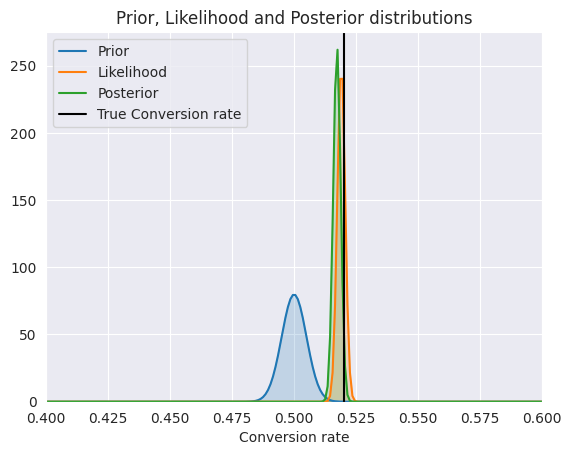

In [257]:
from scipy.stats import beta, binom

def plot_bayesian_update(alpha_prior, beta_prior, n, c):
    # Generate a range of possible theta values
    x = np.linspace(0, 1, 1000)

    # Prior distribution
    prior = beta.pdf(x, alpha_prior, beta_prior)
    plt.plot(x, prior, label='Prior', color = _colors[0])
    plt.fill_between(x, prior, color = _colors[0], alpha=0.2)

    # Likelihood - binomial (normalised s.t. area under curve is equal to 1, for visualization)
    likelihood = binom.pmf(c, n, x)
    normalized_likelihood = likelihood / np.trapz(likelihood, x)
    plt.plot(x, normalized_likelihood, label='Likelihood', color = _colors[1])
    plt.fill_between(x, normalized_likelihood, color = _colors[1], alpha=0.2)

    # Posterior distribution
    posterior = beta.pdf(x, alpha_prior + c, beta_prior + n - c)
    plt.plot(x, posterior, label='Posterior', color = _colors[2])
    plt.fill_between(x, posterior, color = _colors[2], alpha=0.2)

    plt.axvline(x = T["true_prob"], label = "True Conversion rate", color = "black")

    plt.legend()
    plt.title('Prior, Likelihood and Posterior distributions')
    plt.xlabel('Conversion rate')
    plt.xlim(0.4, 0.6) # Manually change x range
    plt.ylim(bottom = 0)
    plt.show()

# Example usage:
print("Treatment group: ")
plot_bayesian_update(T_prior["alpha"], T_prior["beta"], T["n"], T["converted"])

---
# Part 5: Early Stopping

In order to improve testing efficiency, instead of waiting for the complete dataset, we can utilize **sequential testing methods**. These methods involve collecting and analyzing data in sequential stages or increments. At each stage, interim results are evaluated, and a decision is made to either stop or continue sampling based on statistical early stopping rule criteria. Whereas in typical frequentist/classical methods, we'd rely on p-values; Bayesian Sequential Testing use bayes factors for this purpose.

Given a Bayes factor (BF) and a threshold ```k``` (hyperparameter explained in next section), Our implementation defines the stopping rule as follows:

$$
\text{For each interim test:    } \left\{
\begin{array}{ll}
BF > k & \text{STOP & Reject } H_0 \\
BF < \frac{1}{k} & \text{STOP & Accept } H_0 \\
\text{otherwise} & \text{continue sampling}
\end{array}
\right.
$$

This iterative process continues until sufficiently strong evidence is identified or a predetermined maximum sample size is reached.

User input:
- ```prob_early_stop``` = desired level of certainty before early stopping (%) = user-friendly transformation of ```k```
- ```interim_test_interval``` = number of samples collected between each iterative test (larger interval → less tests → less compute)
- ```print_es_progress``` = Print progress in terms of samples collected

In [258]:
prob_early_stop = 0.95
interim_test_interval = 100
print_es_progress = False # Print progress

## Interpretation hyperparameter *k*


Recall that the Bayes factor is defined as a ratio of hypothesis marginal likelihoods:

$$ \text{Bayes Factor} = BF_{1|0} = \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)} $$

Given its numerical value represents odds in favor of the numerator (in this design the $H_1$). For example, a BF of 3 can be interpreted as 3:1 odds in favor of the $H_1$ and consequently a 75% probability when compared to its counterpart in the denominator ($H_0$). The hyperparameter ```k``` are the odds (k:1 in favor of $H_1$) that we define to be sufficiently conclusive to early stop. consequently, we can use $\frac{1}{k}$ to symmetrically construct a stopping rule in favor of $H_0$ too.

However, working with k can be unintuitive. Therefore decided to change the user input format to a probability (```prob_early_stop```), which we can then quite trivially transform to the corresponding odds, as shown below.

In [259]:
# Convert probability to odds (Bayes factors stopping rule)
k = (prob_early_stop * 100) / (100 - (prob_early_stop * 100))
print(f"Given {prob_early_stop}% early stopping certainty: k = {k}")

# Prior (marginal likelihood)
alpha_0, beta_0 = C_prior["alpha"], C_prior["beta"] # H0 (By design, equal to Prior Control)
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"] # Treatment
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"] # Control

Given 0.95% early stopping certainty: k = 19.0


Bayes Factor Early stopping implementation:

In [260]:
# Initialise
bayes_factor, n_observed = 0, 0
interim_tests = []

while n_observed <= T["n"]:
    c_t, n_t = sum(T["sample"][:n_observed]), n_observed
    c_c, n_c = sum(C["sample"][:n_observed]), n_observed

    # Get & store (beta) Bayes Factor
    bayes_factor = beta_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)
    interim_tests.append((n_observed, bayes_factor))

    # option to print progress if desired
    if print_es_progress == True:
        print(f"n: {n_observed}/{T['n']}, BF: {bayes_factor}")

    # Stopping criteria
    if (bayes_factor > k or bayes_factor < 1/k):
        break

    # Extend sample & get conversions
    n_observed += interim_test_interval

## Early Stopping visualisation & performance metrics

The following plot visualises the movement of the early stopping criteria (BF) across the iterative interim tests for better insights in the convergence behaviour and speed.

- Both early stopping thesholds are highlighted
- y-axis uses logarithmic scale for visualisation purposes.
- BF < 1: In favor of $H_0$ → Accept $H_0$, no effect identified (Red)
- BF > 1: In favor of $H_1$ → Reject $H_0$, significant effect identfied (Green)



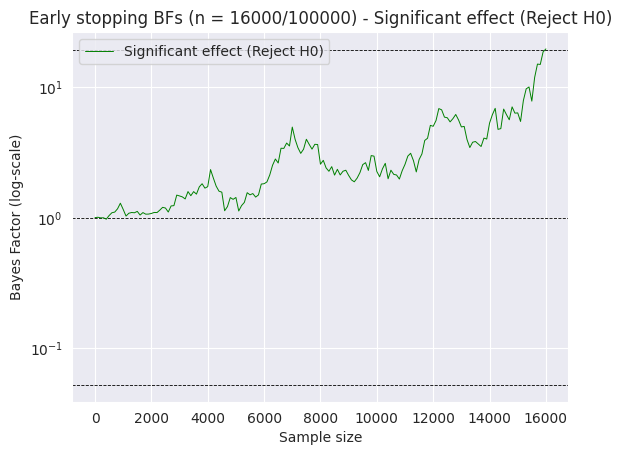

In [261]:
def plot_early_stopping(interim_tests):
    # plot stopping criteria
    plt.axhline(y = 1, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = k, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/k, color = "black", linestyle = "--", linewidth = "0.6")

    # Plot interim testing Bayes-Factor development
    if interim_tests[-1][1] > 1: # Reject H0 (Effect discovery)
        color_i = "green"
        conclusion = "Significant effect (Reject H0)"
    else: # Accept H0 (No effect)
        color_i = "red"
        conclusion = "No effect (Accept H0)"

    x, y = zip(*interim_tests)
    plt.plot(x, y, linestyle = "-", linewidth = 0.7, color = color_i, label = conclusion)

    # Set the y-axis to log scale
    plt.yscale('log')
    plt.xlabel("Sample size")
    plt.ylabel("Bayes Factor (log-scale)")
    plt.legend()
    plt.title(f"Early stopping BFs (n = {interim_tests[-1][0]}/{T['n']}) - {conclusion}")
    plt.show()

plot_early_stopping(interim_tests)

This segment enables us to see what effect the Early Stopping feature had on the experiment, compared to a fixed horizon Bayesian A/B test (metric interpretation is covered in part 4 of this notebook).

In [262]:
# !pip install tabulate
from tabulate import tabulate

# Calculate experimentation metrics
es_prob_effect = round((prior_odds * bayes_factor) / ((prior_odds * bayes_factor) + 1) * 100, 2)
es_uplift = round(c_t/n_t - c_c/n_c, 4)
es_prob_t_wins = prob_treatment_greater_than_control(alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)
es_loss_when_t = expected_loss_when_choosing_treatment(alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)

# Format print statement
headers = ["Metric", "Fixed horizon", "Early stopping"]
table_data = [
    ["n", T['n'], n_t],
    ["posterior", f"{prob_effect}%", f"{es_prob_effect}%"],
    ["uplift", uplift, es_uplift],
    ["P[T > C]", f"{prob_t_wins}%", f"{es_prob_t_wins}%"],
    ["Loss", loss_when_t, es_loss_when_t]
]

# Print the table
print(f"True treatment effect: {round(T['true_prob'] - C['true_prob'], 4)}\n")
print(tabulate(table_data, headers=headers))

True treatment effect: 0.02

Metric     Fixed horizon    Early stopping
---------  ---------------  ----------------
n          100000           16000
posterior  100.0%           95.12%
uplift     0.0186           0.0217
P[T > C]   100.0%           99.91%
Loss       0                0.0018


Visualisation for conversion rate probability distribution estimations for both the fixed horizon and early stopping variant. Useful for visualising potential Bias/Variance trade-offs.

Treatment group (Fixed Horizon) with n = 100000


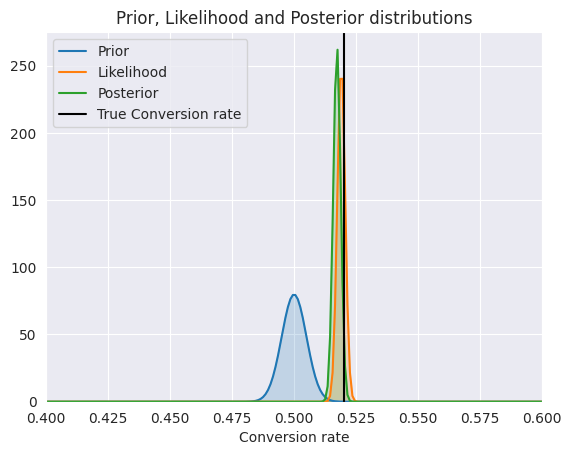

Treatment group (Early Stopping) with n = 16000


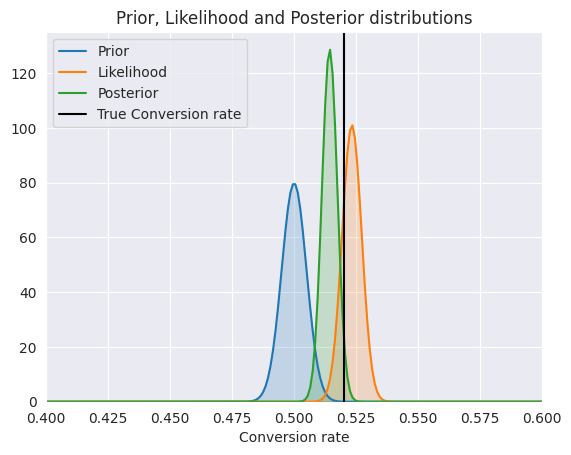

In [263]:
# Visualise differences in distributions for Fixed Horizon & Early Stopping
print(f"Treatment group (Fixed Horizon) with n = {T['n']}")
plot_bayesian_update(T_prior["alpha"], T_prior["beta"], T["n"], T["converted"]) # Fixed horizon
print(f"Treatment group (Early Stopping) with n = {n_t}")
plot_bayesian_update(T_prior["alpha"], T_prior["beta"], n_t, c_t) # Early stopping